In [1]:
from eda_imports import *

import pysam
from tqdm import tqdm

import kleat.misc.settings as S
import kleat.misc.utils as U
from kleat.misc.apautils import calc_genome_offset
from kleat.evidence import bridge

from visaln import visaln

seaborn not found


In [2]:
DATA_DIR='/projects/btl/zxue/tasrkleat-TCGA-results/tasrkleat-TCGA-analysis-scripts/benchmark-kleat.bk/UHR/C1/tasrkleat-results'

In [3]:
c2g_bam = pysam.AlignmentFile(os.path.join(DATA_DIR, 'align_contigs2genome/cba.sorted.bam'))
r2c_bam = pysam.AlignmentFile(os.path.join(DATA_DIR, 'align_reads2contigs/cba.sorted.bam'))

In [4]:
contig_name = 'A0.R100625'

In [5]:
for contig in c2g_bam:
    if contig.query_name == contig_name:
        if contig.reference_name == 'chr1':
            print(contig.cigarstring)
            break

138S23M35539N111M36422N13M1D12M3I849M2185H


In [6]:
contig.is_reverse

True

In [7]:
contig.reference_start

204453583

In [8]:
reads = r2c_bam.fetch(contig.query_name)
bdg_read_info = []
for rd in reads:
    if bridge.is_a_bridge_read(rd):
        if contig.is_reverse:
            contig_len = contig.infer_query_length(always=True)
            bdg_read_info.append([
                contig_len - rd.reference_end,
                contig_len - rd.reference_start,
                f'rev({rd.cigarstring})',
                tuple(reversed(rd.cigartuples))
            ])
        else:
            raise NotImplementedError

In [9]:
df_bdg_read = pd.DataFrame(bdg_read_info, columns=['reference_start', 'reference_end', 'cigarstring', 'cigartuples'])
df_bdg_read = df_bdg_read.sort_values('reference_start').reset_index(drop=True)

In [10]:
df_bdg_read.shape

(50, 4)

In [11]:
df_bdg_read.iloc[7:].head()

,reference_start,reference_end,cigarstring,cigartuples
7,159,232,rev(73M1S),"((4, 1), (0, 73))"
8,159,232,rev(73M1S),"((4, 1), (0, 73))"
9,190,262,rev(3S72M),"((0, 72), (4, 3))"
10,191,262,rev(4S71M),"((0, 71), (4, 4))"
11,191,262,rev(4S71M),"((0, 71), (4, 4))"


In [12]:
contig_sr = pd.Series(
    [contig.reference_start, contig.reference_end, contig.cigarstring, contig.cigartuples], 
    index=['reference_start', 'reference_end', 'cigarstring', 'cigartuples']
)

In [13]:
contig_sr.to_frame().T

,reference_start,reference_end,cigarstring,cigartuples
0,204453583,204526553,138S23M35539N111M36422N13M1D12M3I849M2185H,"[(4, 138), (0, 23), (3, 35539), (0, 111), (3, 36422), (0, 13), (2, 1), (0, 12), (1, 3), (0, 849), (5, 2185)]"


In [14]:
# contig span
contig_sr.reference_end - contig_sr.reference_start

72970

In [15]:
predicted_clv = 204489253

In [18]:
num_skips = visaln.calc_num_skips(contig)
df_xlims = visaln.calc_xlim_pairs(contig, predicted_clv)

204453299 - 204453751, covering clv False
204488999 - 204489401, covering clv True
204525532 - 204528883, covering clv False


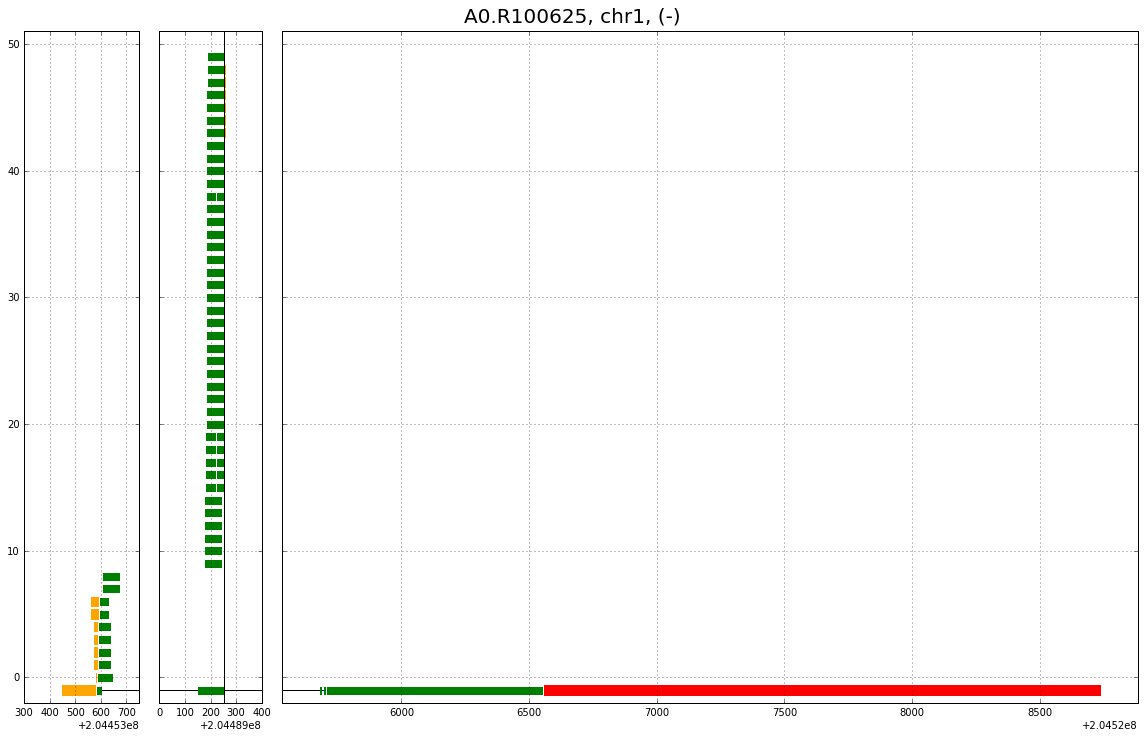

In [23]:
fig, axes = plt.subplots(
    1, num_skips + 1, figsize=(16, 10), sharey=True, gridspec_kw = {'width_ratios':df_xlims.span})
axes = axes.ravel()

for ki, row in df_xlims.iterrows():
    ax = axes[ki]
    height = 0.6
    for k, read in df_bdg_read.iterrows():
        cx = visaln.get_abs_start(read)
        cx = visaln.convert_contig2genome_coord(cx, contig)
        cy = k
#         print(cx, end=', ')
        visaln.draw_alignment(ax, cx, cy, read)

    cx = visaln.get_abs_start(contig)
    visaln.draw_alignment(ax, cx, cy=-1, aln=contig)

    ylim = [-2, df_bdg_read.shape[0] + 1]

    clv = 204489253  # predicted
    ax.plot([clv, clv], ylim, color='black')
    ax.set_ylim(ylim)
    print(f'{row.xmin} - {row.xmax}, covering clv {row.xmin <= clv <= row.xmax}')
    ax.set_xlim(row.xmin, row.xmax)
    ax.grid()
    
strand = '-' if contig.is_reverse else '+'
fig.suptitle(f'{contig.query_name}, {contig.reference_name}, ({strand})', fontsize=20, y =1.02)
plt.tight_layout()